## Parte 2 - Lidando com Dados Tratados

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
#from scipy.ndimage import gaussian_filter1d as gf
from scipy.ndimage import uniform_filter1d as gf
import seaborn as sns
import datetime

#### Trabalhos FUTUROS:
- Identificar o Numero de Estacoes por Estado
- Número de estacoes Perdidas por Estado e relativo
- Acumulado mensal 

### Identificando os modos POD e plotando 
Aqui, partiremos dos dados temporais de indíce pluviométrico tratados na parte 1. Os dados, embora localizados espacialmente, serão associados a uma cidade para melhor visualização dos modos. Em seguida, iremos utilizar de interpolação para estimar informação sobre as cidades que não incluem uma estação em seu território.  

As saídas do código abaixo serão
- mapa de modos POD
- influência de cada modo ao longo do tempo

In [2]:
Ind_Pluv = pd.read_csv('./Salvos/Indice_Pluviometrico_x_Tempo2.csv', sep=',')
Loc = gpd.read_file('./Salvos/Infos_x_Localizacao2.csv', 
                    GEOM_POSSIBLE_NAMES="geometry", 
                    KEEP_GEOM_COLUMNS="NO")

### Proper Ortoghonal Decomposition

In [3]:
n_modos = 12
Chuva = np.zeros((int(1+Ind_Pluv.shape[0]/(24*7)), int(Ind_Pluv.shape[1])  ))

aux = np.array(Ind_Pluv)

for i,r in enumerate(np.arange(0,Ind_Pluv.shape[0],24*7)):
    Chuva[ i, : ] = aux[ r: r+24*7, : ].mean(axis=0) 


m = len(Chuva)
Chuva_desvio = Chuva - Chuva.mean(axis=0)

#Metodo mais simples
Cov = (1/(m-1))*np.dot( Chuva_desvio.T, Chuva_desvio)
Lambda, Phi = np.linalg.eig(Cov)

k = np.argsort(Lambda)[::-1] #Ordenando autovalores do maior para o menor 
Lambda = Lambda[k]
Phi = Phi[:,k]

A = np.dot(Chuva_desvio, Phi )

#As colunas de Phi sao os Modos POD
Modos = gpd.GeoDataFrame()
Modos['Código'] = Ind_Pluv.columns
for k in np.arange(n_modos):
    Modos[f'Modo_{k+1}'] = np.real(Phi[:,k])

In [4]:
Loc2 = Loc.copy()


uf_to_regiao = {
    'AC': 'Norte', 'AL': 'Nordeste', 'AP': 'Norte', 'AM': 'Norte', 'BA': 'Nordeste',
    'CE': 'Nordeste', 'DF': 'Centro-Oeste', 'ES': 'Sudeste', 'GO': 'Centro-Oeste',
    'MA': 'Nordeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'MG': 'Sudeste',
    'PA': 'Norte', 'PB': 'Nordeste', 'PR': 'Sul', 'PE': 'Nordeste', 'PI': 'Nordeste',
    'RJ': 'Sudeste', 'RN': 'Nordeste', 'RS': 'Sul', 'RO': 'Norte', 'RR': 'Norte',
    'SC': 'Sul', 'SP': 'Sudeste', 'SE': 'Nordeste', 'TO': 'Norte'
}

# Adicionar a coluna 'Região' ao DataFrame usando o método map
Loc2['Região'] = Loc2['UF'].map(uf_to_regiao)


/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype

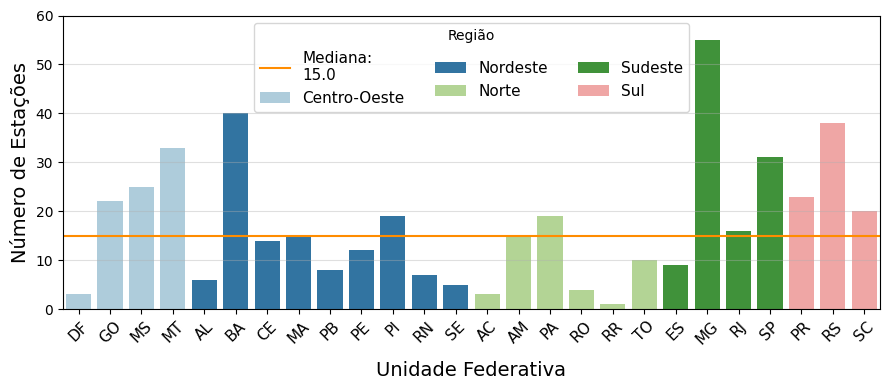

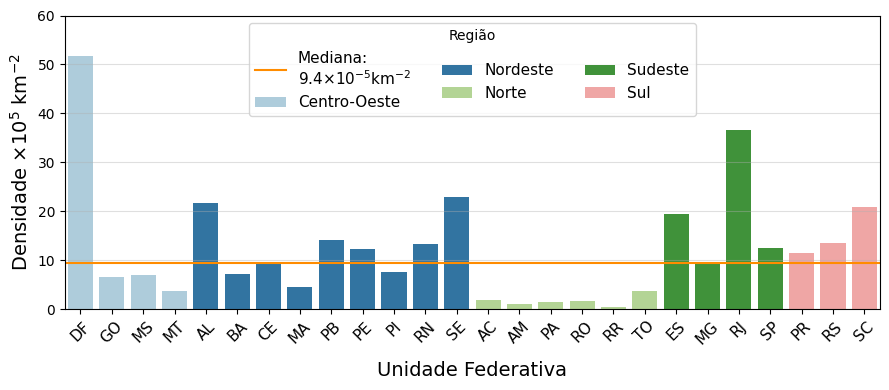

In [5]:
mapeamento_area = {
    'AC': 164123.7, 'AL': 27767.7, 'AP': 142814.6, 'AM': 1570745.7, 'BA': 564733.2,
    'CE': 148920.5, 'DF': 5802.0, 'ES': 46095.6, 'GO': 340111.8, 'MA': 331937.4,
    'MT': 903366.2, 'MS': 357145.5, 'MG': 586521.1, 'PA': 1247954.7, 'PB': 56585.0,
    'PR': 199307.9, 'PE': 98311.6, 'PI': 251529.2, 'RJ': 43780.2, 'RN': 52811.1,
    'RS': 281730.2, 'RO': 237590.7, 'RR': 224300.5, 'SC': 95730.7, 'SP': 248222.4,
    'SE': 21915.1, 'TO': 277620.9
}

# Contar as instâncias por estado (UF) e região
contagem = Loc2.groupby(['UF', 'Região']).size().reset_index(name='Contagem')

# Adicionar a coluna "Área" ao DataFrame de contagem
contagem['Área_km²'] = contagem['UF'].map(mapeamento_area)

# Calcular a densidade de instâncias por km²
contagem['Densidade'] = 1e5*contagem['Contagem'] / contagem['Área_km²']

# Ordenar por região e depois por UF
contagem = contagem.sort_values(by=['Região', 'UF'])



# Plotar o gráfico de barras usando Seaborn
plt.figure(figsize=(9, 4))
densidade_media = contagem['Contagem'].median()
plt.grid(alpha=0.4, zorder=-1.0)
plt.axhline(densidade_media, color='darkorange', linestyle='-', lw=1.5,label='Mediana:\n' +f'{densidade_media:.1f}')
sns.barplot(data=contagem, x='UF', y='Contagem', hue='Região', dodge=False, palette="Paired")

# Adicionar legendas e rótulos
plt.xlabel('Unidade Federativa',fontsize=14, labelpad=10)
plt.ylabel('Número de Estações',fontsize=14)
#plt.title('Número Absoluto de Estações por Estado e Região',fontsize=14)
plt.xticks(rotation=45,fontsize=11)
plt.legend(title='Região',ncol=3,fontsize=11,loc=9)
plt.ylim(0,60)

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.savefig('Estacoes_UF_Reg.png',dpi=300)


plt.figure(figsize=(9, 4)) #------------------------------------------------------------
# Calcular a densidade média
densidade_media = contagem['Densidade'].median()
plt.grid(alpha=0.4, zorder=-1.0)
plt.axhline(densidade_media, color='darkorange', linestyle='-', lw=1.5,label='Mediana:\n' +f'{densidade_media:.1f}'+r'$\times$10$^{-5}$km$^{-2}$')
sns.barplot(data=contagem, x='UF', y='Densidade', hue='Região', dodge=False, palette="Paired")



plt.ylim(0,60)
plt.xlabel('Unidade Federativa',fontsize=14, labelpad=10)
plt.ylabel('Densidade '+r'$\times$10$^5$ ' + r'km$^{-2}$',fontsize=14      )
#plt.title('Densidade Numérica de Estações por Estado e Região',fontsize=14)
plt.xticks(rotation=45,fontsize=11)
plt.legend(title='Região',ncol=3,fontsize=11,loc=9)

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.savefig('Densidade_UF_Reg.png',dpi=300)



In [7]:
contagem_uf

NameError: name 'contagem_uf' is not defined

##### Plot dos Resultados 

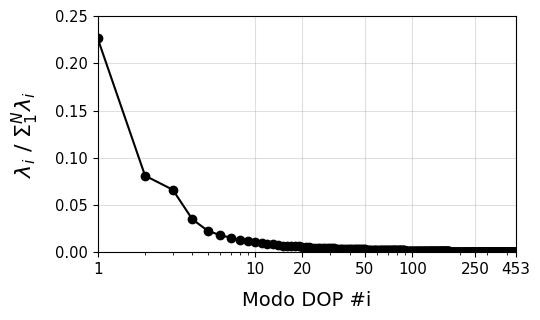

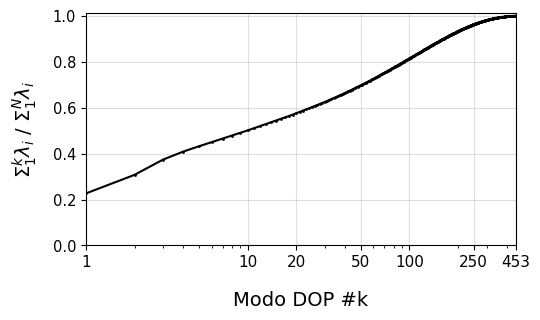

In [8]:
#--------------------------------------------------
#--------------------------------------------------
#--------------------------------------------------
plt.figure(figsize=(5.5,3.3)) #------------------------
plt.semilogx( np.arange(1,len(Lambda)+1),    Lambda/Lambda.sum(),   'ko-' )

plt.xlim(1,453)

plt.yticks(np.arange(0,0.251,0.05),fontsize=10.5)
plt.ylim(0,0.25)




plt.xticks([1,10,20,50,100,250,453],[1,10,20,50,100,250,453],fontsize=11)

plt.ylabel(r"$\lambda_i$"+' / '+r"$\Sigma_1^N\lambda_i$",fontsize=16, labelpad=10)
plt.xlabel('Modo DOP #i',fontsize=14, labelpad=10)

plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig('Lambda.png',dpi=300)


#--------------------------------------------------
#--------------------------------------------------
#--------------------------------------------------
plt.figure(figsize=(5.5,3.3)) #------------------------
plt.semilogx(np.arange(1,454),np.cumsum(Lambda)/Lambda.sum(),'ko-',ms=1)
plt.xticks([1,10,20,50,100,250,453],[1,10,20,50,100,250,453],fontsize=11)
plt.xlim(1,453)

plt.yticks(np.arange(0,1.1,0.1),fontsize=10.5)
plt.ylim(0,1.01)

plt.xlabel('Modo DOP #k',fontsize=14, labelpad=15)
plt.ylabel(  r"$\Sigma_1^k\lambda_i$"+' / '+r"$\Sigma_1^N\lambda_i$"  ,fontsize=14, labelpad=10)
plt.yticks(np.linspace(0,1,6))

plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig('Cumsum.png',dpi=300)


### Associando cada Estação à sua respectiva Cidade
Cerca de 9% dos munícipios do páis possuem estação do Inmet. Para facilitar nossa visualização, vamos estender os dados registrados paras estações aos municípios que as contém. Mas onde conseguir os mapas dos municípios? No site do IBGE há dados sobre os limites dos municípios no formato shapefile (shp), adequado para a construção de mapas. 

In [9]:
#Abrindo limites municipais
Cidades = gpd.read_file('./2022/BR_Municipios_2022/BR_Municipios_2022.shp')
Cidades["centroid"] = Cidades["geometry"].centroid

#Abrindo limites estaduais
UF = gpd.read_file('./2022/BR_UF_2022/BR_UF_2022.shp')

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_56861/102083001.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Cidades["centroid"] = Cidades["geometry"].centroid


#### Cruzando Código Com Município

In [10]:
for k in np.arange(n_modos):
    Cidades[f'Modo_{k+1}'] = np.NAN

for indice in range(Cidades.shape[0]-1):

    pip = Loc.within(Cidades.loc[indice, 'geometry'])
    
    if pip.sum() > 0: 
        i = Loc.loc[pip, 'Código']
        for k in np.arange(len(Modos.columns) - 1):
            try:
                Cidades.loc[indice, f'Modo_{k+1}'] = Modos.loc[ (Modos['Código'] == i.values[0]) ][f'Modo_{k+1}'].values[0]
            except:
                Cidades.loc[indice, f'Modo_{k+1}'] = np.NAN
Cidades

CD_MUN                 NM_MUN SIGLA_UF  AREA_KM2  \
0     1100015  Alta Floresta D'Oeste       RO  7067.127   
1     1100023              Ariquemes       RO  4426.571   
2     1100031                 Cabixi       RO  1314.352   
3     1100049                 Cacoal       RO  3793.000   
4     1100056             Cerejeiras       RO  2783.300   
...       ...                    ...      ...       ...   
5567  5222005             Vianópolis       GO   954.115   
5568  5222054         Vicentinópolis       GO   733.794   
5569  5222203               Vila Boa       GO  1052.593   
5570  5222302          Vila Propício       GO  2181.593   
5571  5300108               Brasília       DF  5760.784   

                                               geometry  \
0     POLYGON ((-62.00806 -12.13379, -62.00784 -12.2...   
1     POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...   
2     POLYGON ((-60.52408 -13.32137, -60.37162 -13.3...   
3     POLYGON ((-61.35502 -11.50452, -61.35524 -11.5...   
4     POLYGON ((-60.82135 -13.11910, -60.81773 -13.1...   
...                                                 ...   
5567  POLYGON ((-48.31126 -16.84221, -48.31170 -16.8...   
5568  POLYGON ((-49.73613 -17.74427, -49.73624 -17.7...   
5569  POLYGON ((-47.07780 -15.06364, -47.07799 -15.0...   
5570  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...   
5571  POLYGON ((-48.01472 -16.04996, -48.01573 -16.0...   

                         centroid    Modo_1    Modo_2    Modo_3    Modo_4  \
0     POINT (-62.27466 -12.47013)       NaN       NaN       NaN       NaN   
1      POINT (-62.95726 -9.95189)  0.069374 -0.007153  0.027406  0.004070   
2     POINT (-60.63981 -13.47488)       NaN       NaN       NaN       NaN   
3     POINT (-61.32473 -11.30129)  0.071062 -0.017359  0.015745 -0.003157   
4     POINT (-61.26095 -13.20356)       NaN       NaN       NaN       NaN   
...                           ...       ...       ...       ...       ...   
5567  POINT (-48.44077 -16.81281)       NaN       NaN       NaN       NaN   
5568  POINT (-49.87269 -17.72364)       NaN       NaN       NaN       NaN   
5569  POINT (-47.06237 -14.99312)       NaN       NaN       NaN       NaN   
5570  POINT (-48.81354 -15.26968)       NaN       NaN       NaN       NaN   
5571  POINT (-47.79685 -15.78117)       NaN       NaN       NaN       NaN   

        Modo_5    Modo_6    Modo_7    Modo_8    Modo_9   Modo_10   Modo_11  \
0          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1     0.052199  0.026559 -0.009754 -0.047447  0.004093  0.007441 -0.001799   
2          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3     0.096441  0.032019 -0.010281 -0.075410  0.024990 -0.044662  0.011996   
4          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...        ...       ...       ...       ...       ...       ...       ...   
5567       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5568       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5569       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5570       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5571       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

       Modo_12  
0          NaN  
1    -0.084161  
2          NaN  
3    -0.065453  
4          NaN  
...        ...  
5567       NaN  
5568       NaN  
5569       NaN  
5570       NaN  
5571       NaN  

[5572 rows x 18 columns]

#### Plot de um Modo POD
Note os vazios, em cinza claro, indicando a ausência de estações em alguns municípios.
O que significam as cores?
Quando dois municípios apresentam cores inversas, diz-se que tais município possui correlação negativo quanto à variação de chuva: quando um dos municípios apresentam aumento de chuva, o outro apresenta diminuição, e vice-versa. Aqui, azul e vermelha representam cores opostas.  

(-74.0, -34.0, -35.7023289475499, 7.222992030550026)

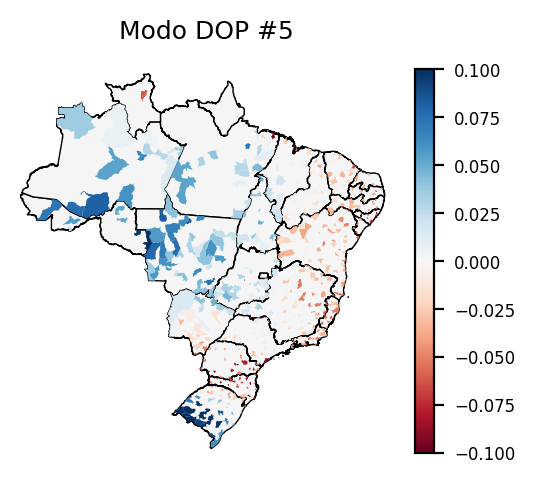

In [11]:
#k = 5
%matplotlib inline
#fig, ax = plt.subplots(ncols=1, nrows=1 ,figsize=(3,3),dpi=200)

#UF.plot(facecolor="whitesmoke", edgecolor="black", ax=ax,lw=0.5)
#v = max(np.abs(Cidades[f'Modo_{k}'].min()), np.abs(Cidades[f'Modo_{k}'].max())  )
#Cidades.plot(ax=ax,column=f'Modo_{k}',cmap='RdBu',legend=True,vmin=-0.1,vmax=0.1)

#ax.set_title(f"Modo DOP {k}", fontsize=15)
#ax.axis("off")

k = 5
%matplotlib inline
#fig, ax = plt.subplots(ncols=1, nrows=1 ,figsize=(3,3),dpi=200)

#UF.plot(facecolor="whitesmoke", edgecolor="black", ax=ax,lw=0.5)
#v = max(np.abs(Cidades[f'Modo_{k}'].min()), np.abs(Cidades[f'Modo_{k}'].max())  )
#Cidades.plot(ax=ax,column=f'Modo_{k}',cmap='RdBu',legend=True,vmin=-0.1,vmax=0.1)

#ax.set_title(f"Modo DOP {k}", fontsize=15)
#ax.axis("off")

fig, ax = plt.subplots(ncols=1, nrows=1 ,figsize=(3,3),dpi=200)

UF.plot(facecolor="whitesmoke", edgecolor="black", ax=ax, lw=0.5)

#v = max(np.abs(Cidades[f'Modo_{k}'].min()), np.abs(Cidades[f'Modo_{k}'].max()))
im = Cidades.plot(ax=ax, column=f'Modo_{k}', cmap='RdBu', vmin=-0.1, vmax=0.1)

# Adicionando manualmente a colorbar
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=-0.1, vmax=0.1))
sm._A = []  # Necessário para o ScalarMappable funcionar sem dados

cbar = fig.colorbar(sm, ax=ax, shrink=0.83)  # ajuste o parâmetro shrink conforme necessário
cbar.ax.tick_params(labelsize=6)

ax.set_title(f"Modo DOP #{k}", fontsize=9)
ax.set_xlim( -74, -34)
ax.axis("off")
#plt.tight_layout


In [86]:
Cidades

CD_MUN                 NM_MUN SIGLA_UF  AREA_KM2  \
0     1100015  Alta Floresta D'Oeste       RO  7067.127   
1     1100023              Ariquemes       RO  4426.571   
2     1100031                 Cabixi       RO  1314.352   
3     1100049                 Cacoal       RO  3793.000   
4     1100056             Cerejeiras       RO  2783.300   
...       ...                    ...      ...       ...   
5567  5222005             Vianópolis       GO   954.115   
5568  5222054         Vicentinópolis       GO   733.794   
5569  5222203               Vila Boa       GO  1052.593   
5570  5222302          Vila Propício       GO  2181.593   
5571  5300108               Brasília       DF  5760.784   

                                               geometry  \
0     POLYGON ((-62.00806 -12.13379, -62.00784 -12.2...   
1     POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...   
2     POLYGON ((-60.52408 -13.32137, -60.37162 -13.3...   
3     POLYGON ((-61.35502 -11.50452, -61.35524 -11.5...   
4     POLYGON ((-60.82135 -13.11910, -60.81773 -13.1...   
...                                                 ...   
5567  POLYGON ((-48.31126 -16.84221, -48.31170 -16.8...   
5568  POLYGON ((-49.73613 -17.74427, -49.73624 -17.7...   
5569  POLYGON ((-47.07780 -15.06364, -47.07799 -15.0...   
5570  POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...   
5571  POLYGON ((-48.01472 -16.04996, -48.01573 -16.0...   

                         centroid    Modo_1    Modo_2    Modo_3    Modo_4  \
0     POINT (-62.27466 -12.47013)       NaN       NaN       NaN       NaN   
1      POINT (-62.95726 -9.95189)  0.069374 -0.007153  0.027406  0.004070   
2     POINT (-60.63981 -13.47488)       NaN       NaN       NaN       NaN   
3     POINT (-61.32473 -11.30129)  0.071062 -0.017359  0.015745 -0.003157   
4     POINT (-61.26095 -13.20356)       NaN       NaN       NaN       NaN   
...                           ...       ...       ...       ...       ...   
5567  POINT (-48.44077 -16.81281)       NaN       NaN       NaN       NaN   
5568  POINT (-49.87269 -17.72364)       NaN       NaN       NaN       NaN   
5569  POINT (-47.06237 -14.99312)       NaN       NaN       NaN       NaN   
5570  POINT (-48.81354 -15.26968)       NaN       NaN       NaN       NaN   
5571  POINT (-47.79685 -15.78117)       NaN       NaN       NaN       NaN   

        Modo_5    Modo_6    Modo_7    Modo_8    Modo_9   Modo_10   Modo_11  \
0          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1     0.052199  0.026559 -0.009754 -0.047447  0.004093  0.007441 -0.001799   
2          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3     0.096441  0.032019 -0.010281 -0.075410  0.024990 -0.044662  0.011996   
4          NaN       NaN       NaN       NaN       NaN       NaN       NaN   
...        ...       ...       ...       ...       ...       ...       ...   
5567       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5568       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5569       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5570       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
5571       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

       Modo_12  
0          NaN  
1    -0.084161  
2          NaN  
3    -0.065453  
4          NaN  
...        ...  
5567       NaN  
5568       NaN  
5569       NaN  
5570       NaN  
5571       NaN  

[5572 rows x 18 columns]

### Substituindo dados faltantes por Interpolação entre Cidades 

In [12]:
#Compartilham index
Cidades_nan  = Cidades[pd.isnull(Cidades).any(axis=1)]
Cidades_real = Cidades[~pd.isnull(Cidades).any(axis=1)]

n = 2 # n=2 é o procedimento comum. Qto maior o valor 'n', menor a correlação a longa distnacia. 
for i in np.arange( len(Cidades_nan) ):
    idx   = Cidades_nan.index[i]
    point = Cidades_nan.loc[ idx, 'centroid'  ]

    d_inv = 1.0/( Cidades_real.distance(point)**n )
    for k in np.arange( len(Modos.columns) - 1 ):
        Cidades_nan.loc[idx, f'Modo_{k+1}'] = (d_inv*Cidades_real[f'Modo_{k+1}']).sum()/d_inv.sum()

Cidades_Full = pd.concat([Cidades_nan, Cidades_real ])

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_56861/3337530466.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  d_inv = 1.0/( Cidades_real.distance(point)**n )
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_56861/3337530466.py:12: RuntimeWarning: invalid value encountered in scalar divide
  Cidades_nan.loc[idx, f'Modo_{k+1}'] = (d_inv*Cidades_real[f'Modo_{k+1}']).sum()/d_inv.sum()


In [13]:
Cidades_real[f'Modo_{k+1}']

1      -0.084161
3      -0.065453
21     -0.029864
31      0.010801
58     -0.046427
          ...   
5510    0.037998
5516    0.025199
5522    0.076370
5547    0.040942
5550   -0.053413
Name: Modo_12, Length: 437, dtype: float64

#### Visualizando um MODO

(-74.0, -34.0, -35.7023289475499, 7.222992030550026)

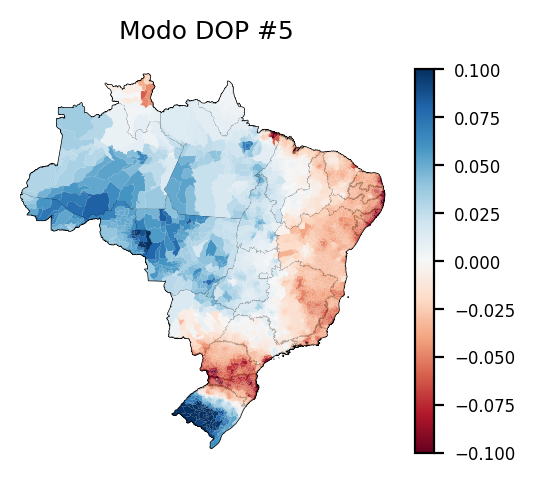

In [15]:
k = 5
%matplotlib inline

fig, ax = plt.subplots(ncols=1, nrows=1 ,figsize=(3,3),dpi=200)

UF.plot(facecolor="whitesmoke", edgecolor="black", ax=ax, lw=0.5)

#v = max(np.abs(Cidades[f'Modo_{k}'].min()), np.abs(Cidades[f'Modo_{k}'].max()))
im = Cidades_Full.plot(ax=ax, column=f'Modo_{k}', cmap='RdBu', vmin=-0.1, vmax=0.1)

# Adicionando manualmente a colorbar
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=-0.1, vmax=0.1))
sm._A = []  # Necessário para o ScalarMappable funcionar sem dados

cbar = fig.colorbar(sm, ax=ax, shrink=0.83)  # ajuste o parâmetro shrink conforme necessário
cbar.ax.tick_params(labelsize=6)

ax.set_title(f"Modo DOP #{k}", fontsize=9)
ax.set_xlim( -74, -34)
ax.axis("off")
#plt.tight_layout

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_56861/3077160915.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


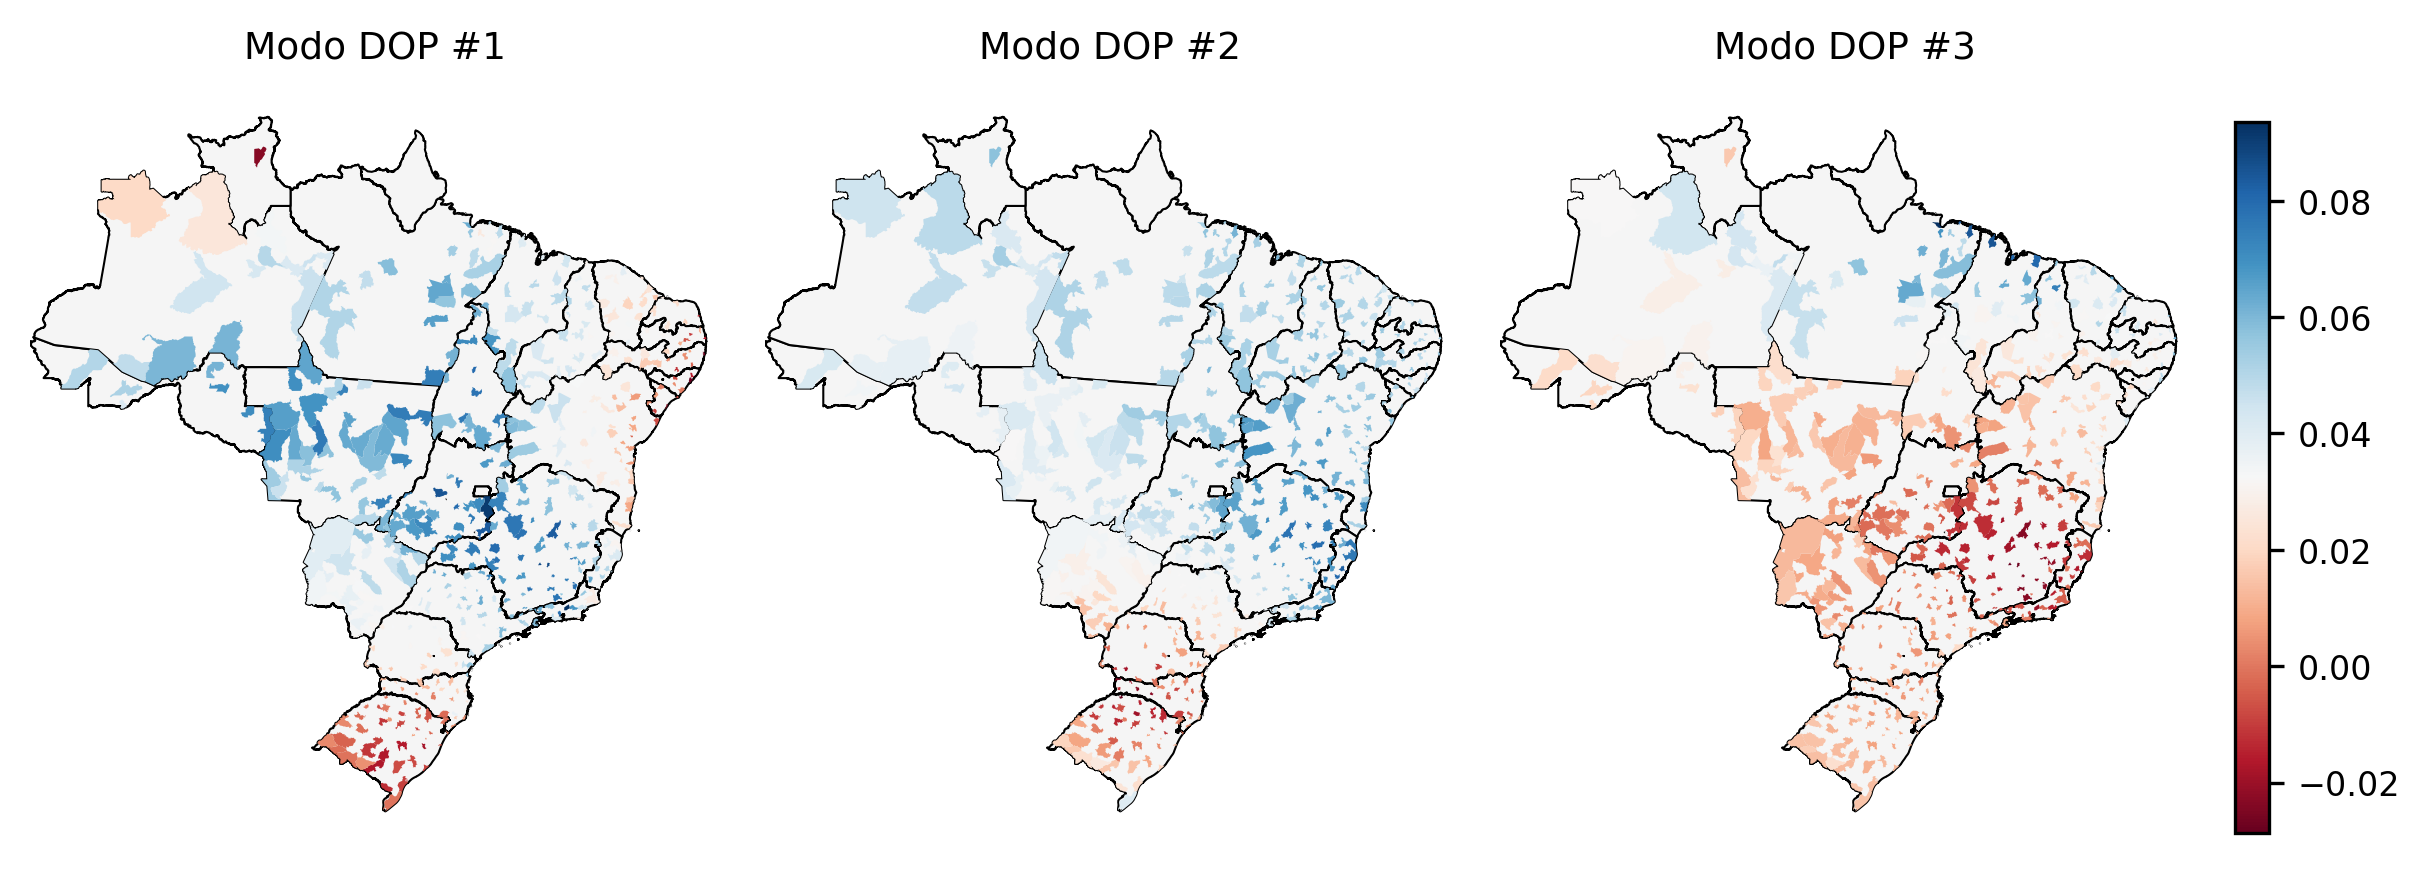

In [16]:
# Suposições de dados
# UF e Cidades_Full devem ser DataFrames geopandas (gpd.GeoDataFrame)

# Definir os limites de x ajustados
xlim_min = -74  # Defina conforme necessário
xlim_max = -34  # Defina conforme necessário

# Número dos modos a serem plotados
modos = [1, 2, 3]

fig, axs = plt.subplots(ncols=3, figsize=(7.5, 3), dpi=300)  # Uma linha e três colunas

# Lista para guardar os objetos ScalarMappable de cada plot
sm_list = []

for idx, k in enumerate(modos):
    UF.plot(facecolor="whitesmoke", edgecolor="black", ax=axs[idx], lw=0.5)

    v = [ np.abs(Cidades_Full[f'Modo_{k}'].min()),  np.abs(Cidades_Full[f'Modo_{k}'].max()) ]
    im = Cidades.plot(ax=axs[idx], column=f'Modo_{k}', cmap='RdBu', vmin=-v[0], vmax=v[1], legend=False)

    # Adicionando manualmente a colorbar e guardando o ScalarMappable
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=-v[0], vmax=v[1]))
    sm_list.append(sm)

    axs[idx].set_title(f"Modo DOP #{k}", fontsize=9)
    axs[idx].set_xlim(xlim_min, xlim_max)
    axs[idx].axis("off")

# Ajustando a posição da colorbar única à direita dos subplots
fig.subplots_adjust(right=0.88, hspace=0.0)
cbar_ax = fig.add_axes([1, 0.09, 0.015, 0.79])  # [left, bottom, width, height]
cbar = fig.colorbar(sm_list[0], cax=cbar_ax)  # Usando o primeiro ScalarMappable da lista


# Ajustando o tamanho da fonte dos ticks da colorbar
cbar.ax.tick_params(labelsize=8)  # ajuste o tamanho da fonte conforme necessário

plt.tight_layout()
#plt.savefig('Modo_Incompleto.png', bbox_inches='tight')


## Resultados

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_1065/3500844511.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


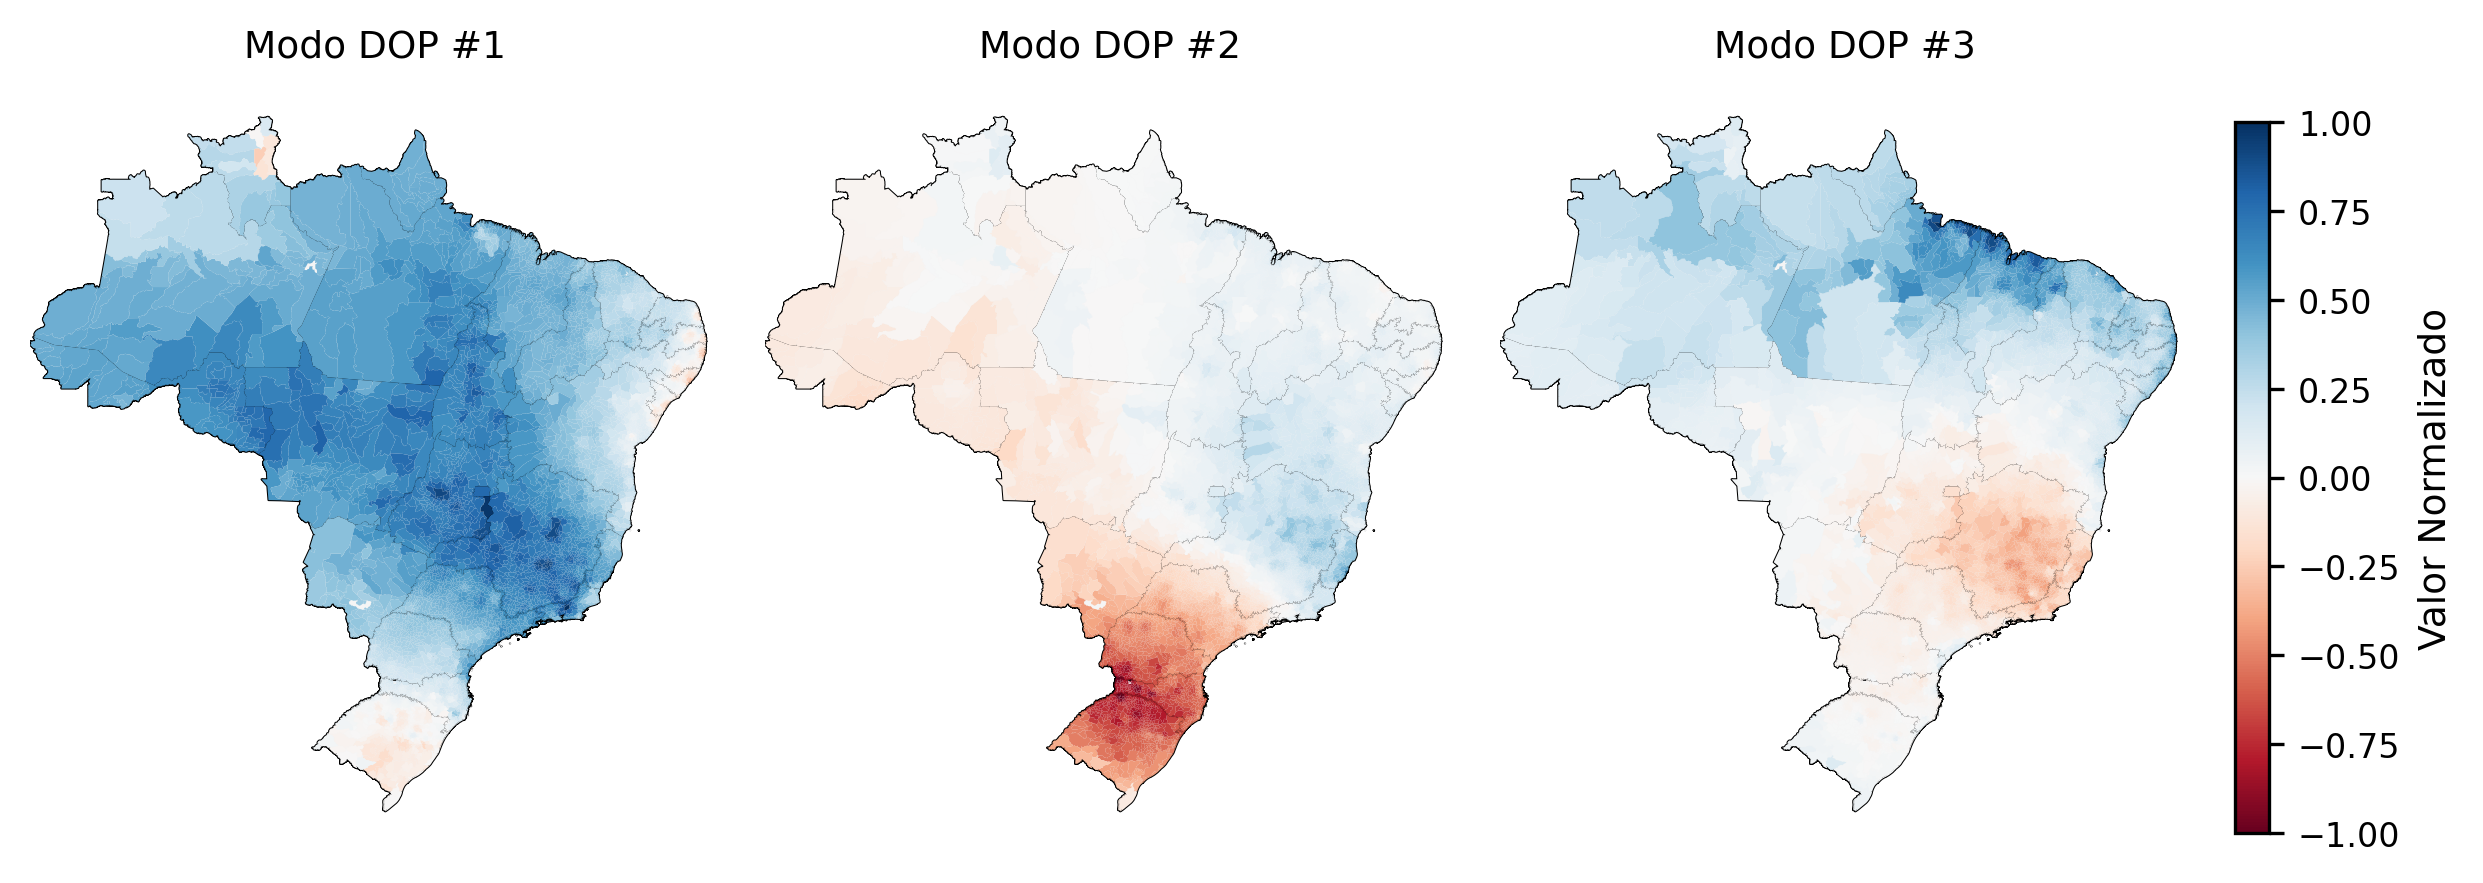

In [156]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np

# Suposições de dados
# UF e Cidades_Full devem ser DataFrames geopandas (gpd.GeoDataFrame)

# Definir os limites de x ajustados
xlim_min = -74  # Defina conforme necessário
xlim_max = -34  # Defina conforme necessário

# Número dos modos a serem plotados
modos = [1, 2, 3]

fig, axs = plt.subplots(ncols=3, figsize=(7.5, 3), dpi=300, sharex=True, sharey=True)  # Uma linha e três colunas

# Lista para guardar os objetos ScalarMappable de cada plot
sm_list = []

for idx, k in enumerate(modos):
    UF.plot(facecolor="whitesmoke", edgecolor="black", ax=axs[idx], lw=0.5)

    # Normalizando os valores do modo
    max_abs_value = max(np.abs(Cidades_Full[f'Modo_{k}'].min()), np.abs(Cidades_Full[f'Modo_{k}'].max()))
    normalized_column = Cidades_Full[f'Modo_{k}'] / max_abs_value

    im = Cidades_Full.assign(**{f'Modo_{k}_norm': normalized_column}).plot(
        ax=axs[idx], column=f'Modo_{k}_norm', cmap='RdBu', vmin=-1, vmax=1, legend=False
    )

    # Adicionando manualmente a colorbar para cada plot com limites fixos de -1 a 1
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=-1, vmax=1))
    sm.set_array([])  # esvazia a array para evitar a colorbar apareça na saída
    sm_list.append(sm)

    axs[idx].set_title(f"Modo DOP #{k}", fontsize=9)
    axs[idx].set_xlim(xlim_min, xlim_max)
    axs[idx].axis("off")

# Ajustando a posição da colorbar única à direita dos subplots
fig.subplots_adjust(right=0.88, hspace=0.0)

cbar_ax = fig.add_axes([1, 0.09, 0.015, 0.79])  # [left, bottom, width, height]
#cbar_ax = fig.add_axes([0.89, 0.12, 0.02, 0.76])  # [left, bottom, width, height]
cbar = fig.colorbar(sm_list[0], cax=cbar_ax)  # Usando o primeiro ScalarMappable da lista
cbar.ax.tick_params(labelsize=8)  # ajuste o tamanho da fonte conforme necessário
cbar.set_label('Valor Normalizado', fontsize=9)  # adicionando um rótulo à colorbar

plt.tight_layout()
plt.savefig('Modo_Completo.png', bbox_inches='tight')
plt.show()


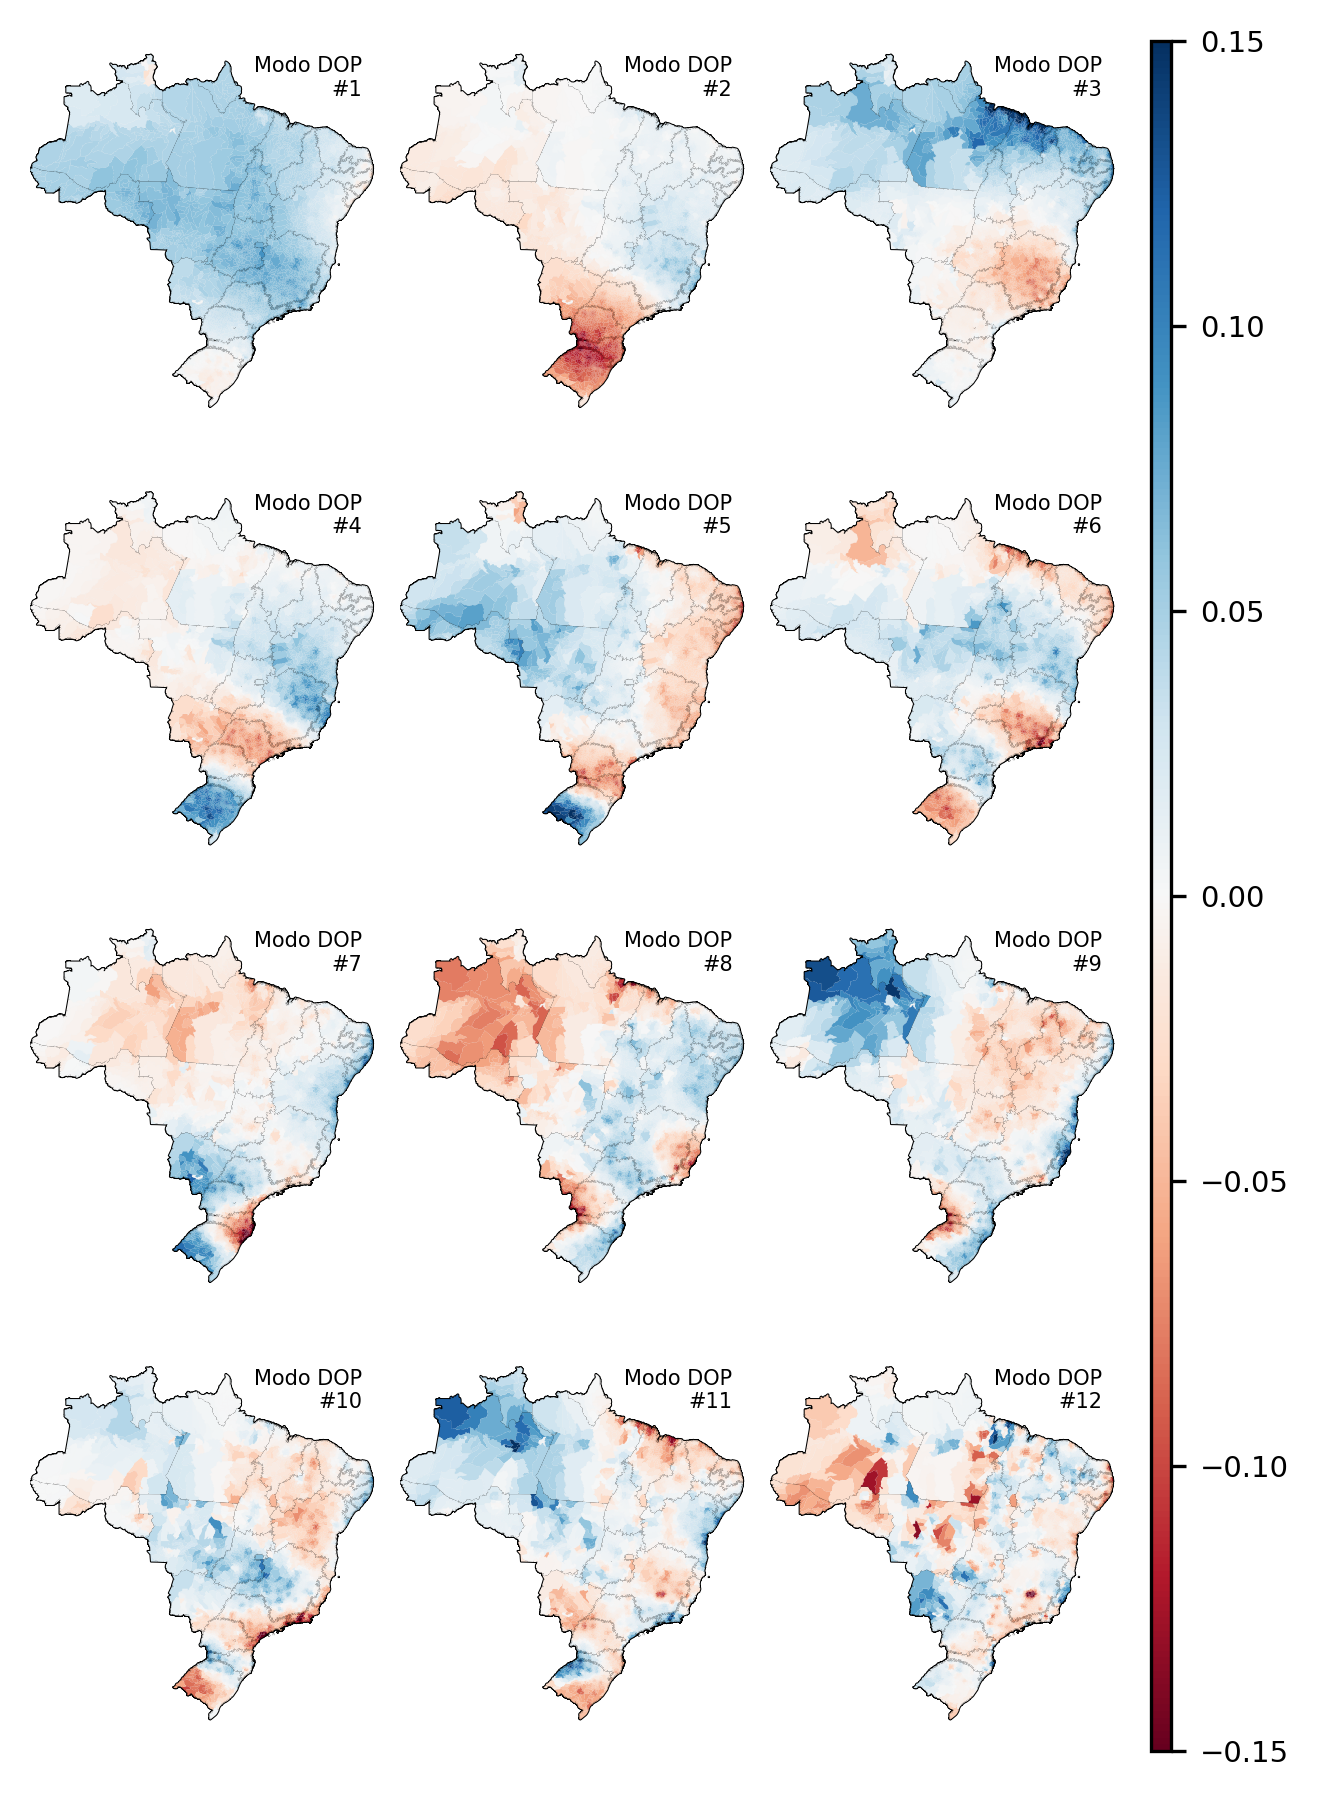

In [19]:
# import matplotlib.pyplot as plt
# import numpy as np
# import geopandas as gpd

# Suposições de dados
# UF e Cidades_Full devem ser DataFrames geopandas (gpd.GeoDataFrame)

# Definir os limites de x ajustados
xlim_min = -74  # Defina conforme necessário
xlim_max = -34  # Defina conforme necessário

# Número de modos a serem plotados
num_modes = 12

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(4.5, 6), dpi=300)  # Ajuste nrows e ncols conforme necessário

# Plotar os dados das cidades
for k in range(num_modes):
    i, j = divmod(k, 3)
    # Plotar o mapa do Brasil com limites estaduais em cada plot
    UF.plot(facecolor="whitesmoke", edgecolor="black", ax=axs[i, j], lw=0.5)

    v = max(np.abs(Cidades_Full[f'Modo_{k+1}'].min()), np.abs(Cidades_Full[f'Modo_{k+1}'].max()))
    im = Cidades_Full.plot(ax=axs[i, j], column=f"Modo_{k+1}", cmap='RdBu', vmin=-0.15, vmax=0.15, legend=False)

    # Escrever o texto no canto superior direito
    axs[i, j].text(0.95, 0.95, f"Modo DOP\n#{k+1}", horizontalalignment='right',
                   verticalalignment='top', transform=axs[i, j].transAxes, fontsize=5)

    axs[i, j].set_xlim(xlim_min, xlim_max)
    axs[i, j].axis("off")

# Ajustando a distância entre os plots
fig.tight_layout(pad=1.2)  # Aumentar o valor de 'pad' para aumentar a distância entre os plots

# Adicionando manualmente a colorbar comum
fig.subplots_adjust(right=0.85)  # Ajustar para dar espaço à colorbar

cbar_ax = fig.add_axes([0.87, 0.02, 0.015, 0.95])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=plt.Normalize(vmin=-0.15, vmax=0.15))
cbar = fig.colorbar(sm, cax=cbar_ax)


# Ajustando o tamanho da fonte dos ticks da colorbar
cbar.ax.tick_params(labelsize=7)  # ajuste o tamanho da fonte conforme necessário

plt.savefig('4x3_Modos_2.png')


### Identificando os Coeficientes
O método POD é capaz de reduzir a distribuição espaço-temporal de chuvas na combinação linear de modos, ou melhor:
$$ Ind_{Pluv}(diário) = A\times PHI^{T}, $$ 
em que $PHI$ são os modos espaciais indentificados para a distribuição de chuvas e $A$ a importância dos respecitivos modos, na forma de um coeficiente, ao longo do tempo, definido por:
\begin{bmatrix}
    a_1(0)  & ... & a_n(0)  \\
    \vdots  & \ddots & \vdots  \\
    a_1(m)  & ... & a_n(m)  
\end{bmatrix}
em que $n$ é o número total de modos e $m$, de observações temporais.  

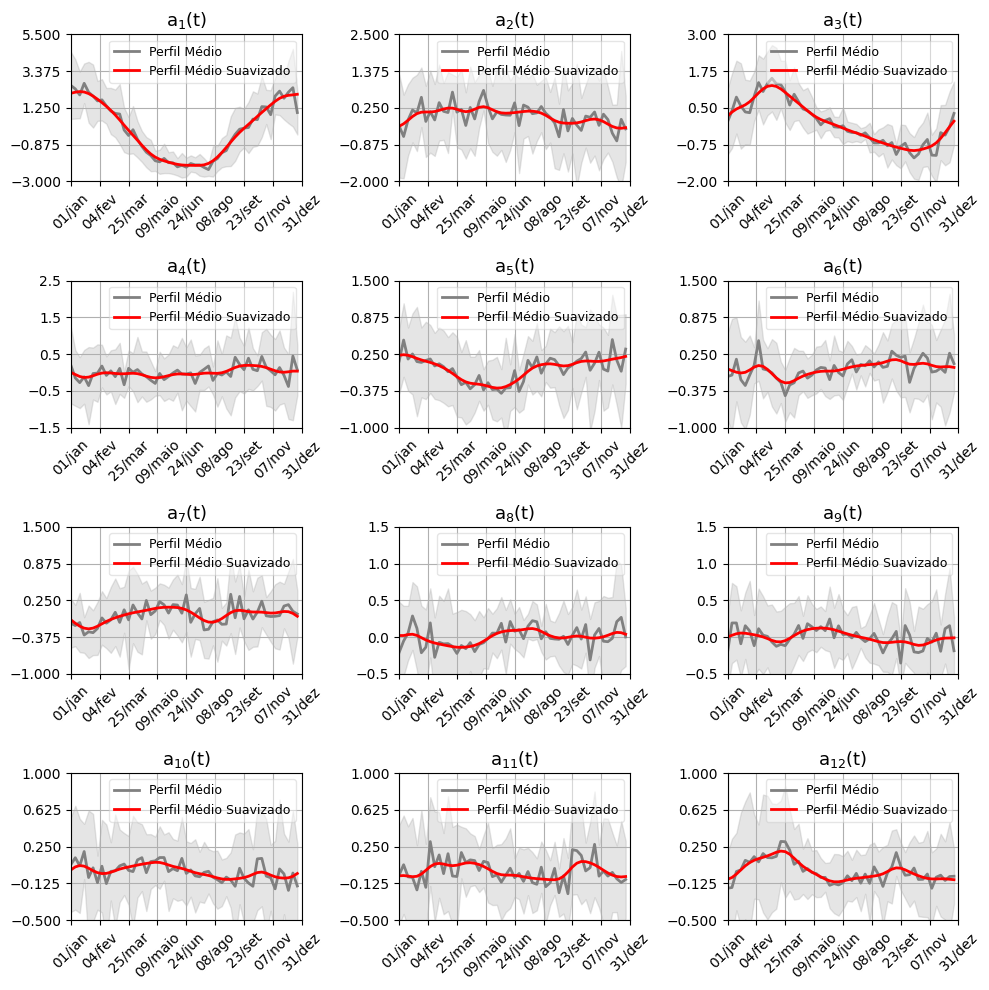

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter as gf

%matplotlib inline

plt.figure(figsize=(10, 10))
x = pd.date_range(start='1-1-2008', end='31-12-2022', periods=A.shape[0])

# Definindo os ticks do eixo x
xticks = np.arange(0, 53, 6.5)
nomes = ['01/jan', '04/fev', '25/mar', '09/maio', '24/jun', '08/ago', '23/set', '07/nov','31/dez']

# Função para plotar dados em um subplot específico
def plot_subplot(k, A):
    plt.subplot(4, 3, k+1)  # Ajusta o número de linhas e colunas aqui
    #plt.xlabel('Semana')
    #plt.ylabel(r"a$_{"+str(k+1)+"}$(t)",fontsize=10,rotation=0)
    plt.xticks(xticks, nomes, rotation=45)  # Definindo os ticks e labels do eixo x

    plt.title(r"a$_{"+str(k+1)+"}$(t)", fontsize=13)

    ultimo_a = A[:-1, k].reshape(14, 52)[-1, :]
    a = A[:-1, k].reshape(14, 52).mean(axis=0)
    da = A[:-1, k].reshape(14, 52).std(axis=0)

    a2 = gf(A[:-1, k].reshape(14, 52).mean(axis=0), 2, mode='wrap')

    plt.plot(a, '-', color='gray', ms=0.1, lw=2, label=f'Perfil Médio', markevery=1)
    plt.fill_between(np.arange(len(a)), a-da, a+da, color='gray', alpha=0.2)
    plt.plot(a2, 'r-', ms=0.1, lw=2, label=f'Perfil Médio Suavizado', markevery=1)


    r_max = 1.1 * (a+da).max()
    r_min = 1.1 * (a-da).min()

    # Fixando os ticks radiais em múltiplos de 0.5
    r_max_rounded = np.ceil(r_max/0.5)*0.5
    r_min_rounded = np.ceil(r_min/0.5)*0.5

    ticks = np.linspace(r_min_rounded, r_max_rounded, 5)
    
    plt.yticks(ticks)
    plt.ylim(r_min_rounded, r_max_rounded)


    plt.legend(ncol=1,framealpha=0.5,fontsize=9)
    plt.xlim(0, 52)
    plt.grid()

# Loop para preencher os subplots
for k in range(12):  # 4 linhas * 3 colunas = 12 subplots
    plot_subplot(k, A)

plt.tight_layout()
plt.savefig('Coeficientes_4x3', dpi=300)
#plt.show()


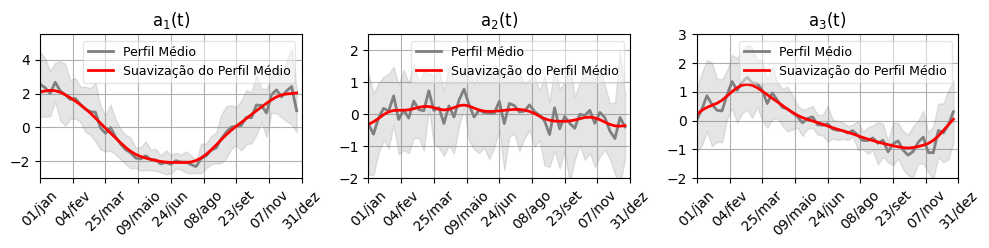

In [208]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter as gf

%matplotlib inline

plt.figure(figsize=(10, 2.58))  # Ajustar o tamanho da figura para uma única linha
x = pd.date_range(start='1-1-2008', end='31-12-2022', periods=A.shape[0])

# Definindo os ticks do eixo x
xticks = np.arange(0, 53, 6.5)
nomes = ['01/jan', '04/fev', '25/mar', '09/maio', '24/jun', '08/ago', '23/set', '07/nov','31/dez']

# Função para plotar dados em um subplot específico
def plot_subplot(k, A):
    plt.subplot(1, 3, k+1)  # Ajusta para uma linha e três colunas
    #plt.ylabel(r"a$_{"+str(k+1)+"}$(t)", fontsize=10, rotation=0)
    plt.xticks(xticks, nomes, rotation=45)  # Definindo os ticks e labels do eixo x

    plt.title(r"a$_{"+str(k+1)+"}$(t)", fontsize=12)

    ultimo_a = A[:-1, k].reshape(14, 52)[-1, :]
    a = A[:-1, k].reshape(14, 52).mean(axis=0)
    da = A[:-1, k].reshape(14, 52).std(axis=0)

    a2 = gf(A[:-1, k].reshape(14, 52).mean(axis=0), 2, mode='wrap')

    plt.plot(a, '-', color='gray', ms=0.1, lw=2, label=f'Perfil Médio', markevery=1)
    plt.fill_between(np.arange(len(a)), a-da, a+da, color='gray', alpha=0.2)
    plt.plot(a2, 'r-', ms=0.1, lw=2, label=f'Suavização do Perfil Médio', markevery=1)

    r_max = 1.1 * (a+da).max()
    r_min = 1.1 * (a-da).min()

    # Fixando os ticks radiais em múltiplos de 0.5
    r_max_rounded = np.ceil(r_max/0.5)*0.5
    r_min_rounded = np.ceil(r_min/0.5)*0.5

    #ticks = np.arange(r_min_rounded, r_max_rounded+0.1, 1)
    
    #plt.yticks(ticks)
    plt.ylim(r_min_rounded, r_max_rounded)


    plt.legend(ncol=1,framealpha=0.5,fontsize=9)
    plt.xlim(0, 52)
    plt.grid()

# Loop para preencher os subplots
for k in range(3):  # Apenas os primeiros 3 gráficos (primeira linha)
    plot_subplot(k, A)

plt.tight_layout()
plt.savefig('Coeficientes_1x3.png', dpi=300)
#plt.show()


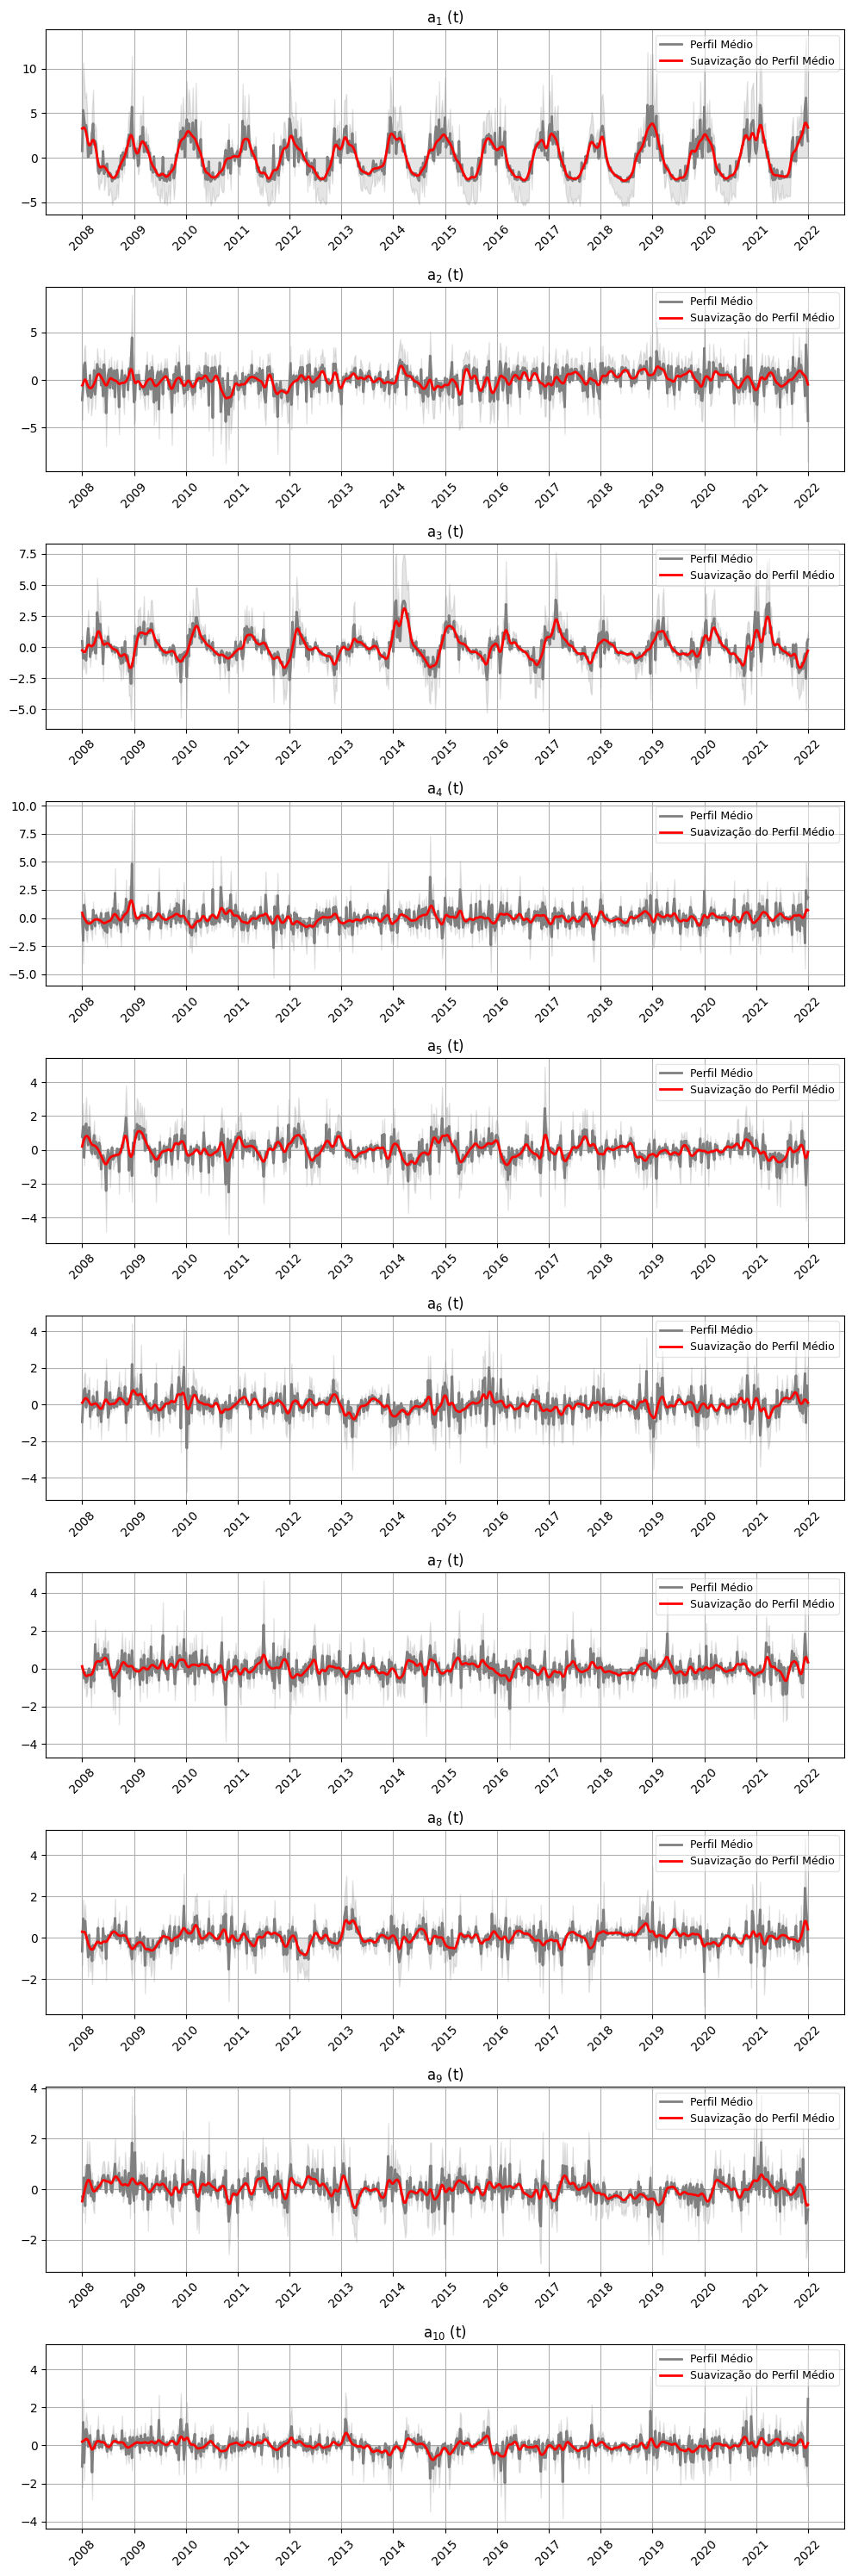

In [209]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter as gf

# Suposição de que A já está definido
# Exemplo:
# A = np.random.randn(728, 3)

plt.figure(figsize=(10, 30))  # Ajustar o tamanho da figura para uma única linha
x = pd.date_range(start='1-1-2008', end='31-12-2022', periods=A.shape[0])

# Definindo os ticks do eixo x
xticks = np.arange(0, len(x), 52)
nomes = [str(year) for year in range(2008, 2023)]

# Função para plotar dados em um subplot específico
def plot_subplot(k, A):
    plt.subplot(10, 1, k + 1)  # Ajusta para uma linha e três colunas
    plt.title(r"a$_{" + str(k + 1) + "}$ (t)", fontsize=12)

    a = A[:, k]
    da = A[:, k]
    a2 = gf(A[:, k], 2, mode='wrap')

    plt.plot(a, '-', color='gray', ms=0.1, lw=2, label=f'Perfil Médio', markevery=1)
    plt.fill_between(np.arange(len(a)), a - da, a + da, color='gray', alpha=0.2)
    plt.plot(a2, 'r-', ms=0.1, lw=2, label=f'Suavização do Perfil Médio', markevery=1)

    r_max = 1.1 * (a + da).max()
    r_min = 1.1 * (a - da).min()
    r_max_rounded = np.ceil(r_max / 0.5) * 0.5
    r_min_rounded = np.ceil(r_min / 0.5) * 0.5

    plt.legend(ncol=1, framealpha=0.5, fontsize=9)
    plt.xticks(xticks, nomes, rotation=45)
    plt.grid()

# Loop para preencher os subplots
for k in range(10):  # Apenas os primeiros 3 gráficos (primeira linha)
    plot_subplot(k, A)

plt.tight_layout()
plt.show()


### Resultados Polares

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_56861/2803087301.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(nomes, fontsize=8)
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_56861/2803087301.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(nomes, fontsize=8)
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_56861/2803087301.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(nomes, fontsize=8)
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_56861/2803087301.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(nomes, fontsize

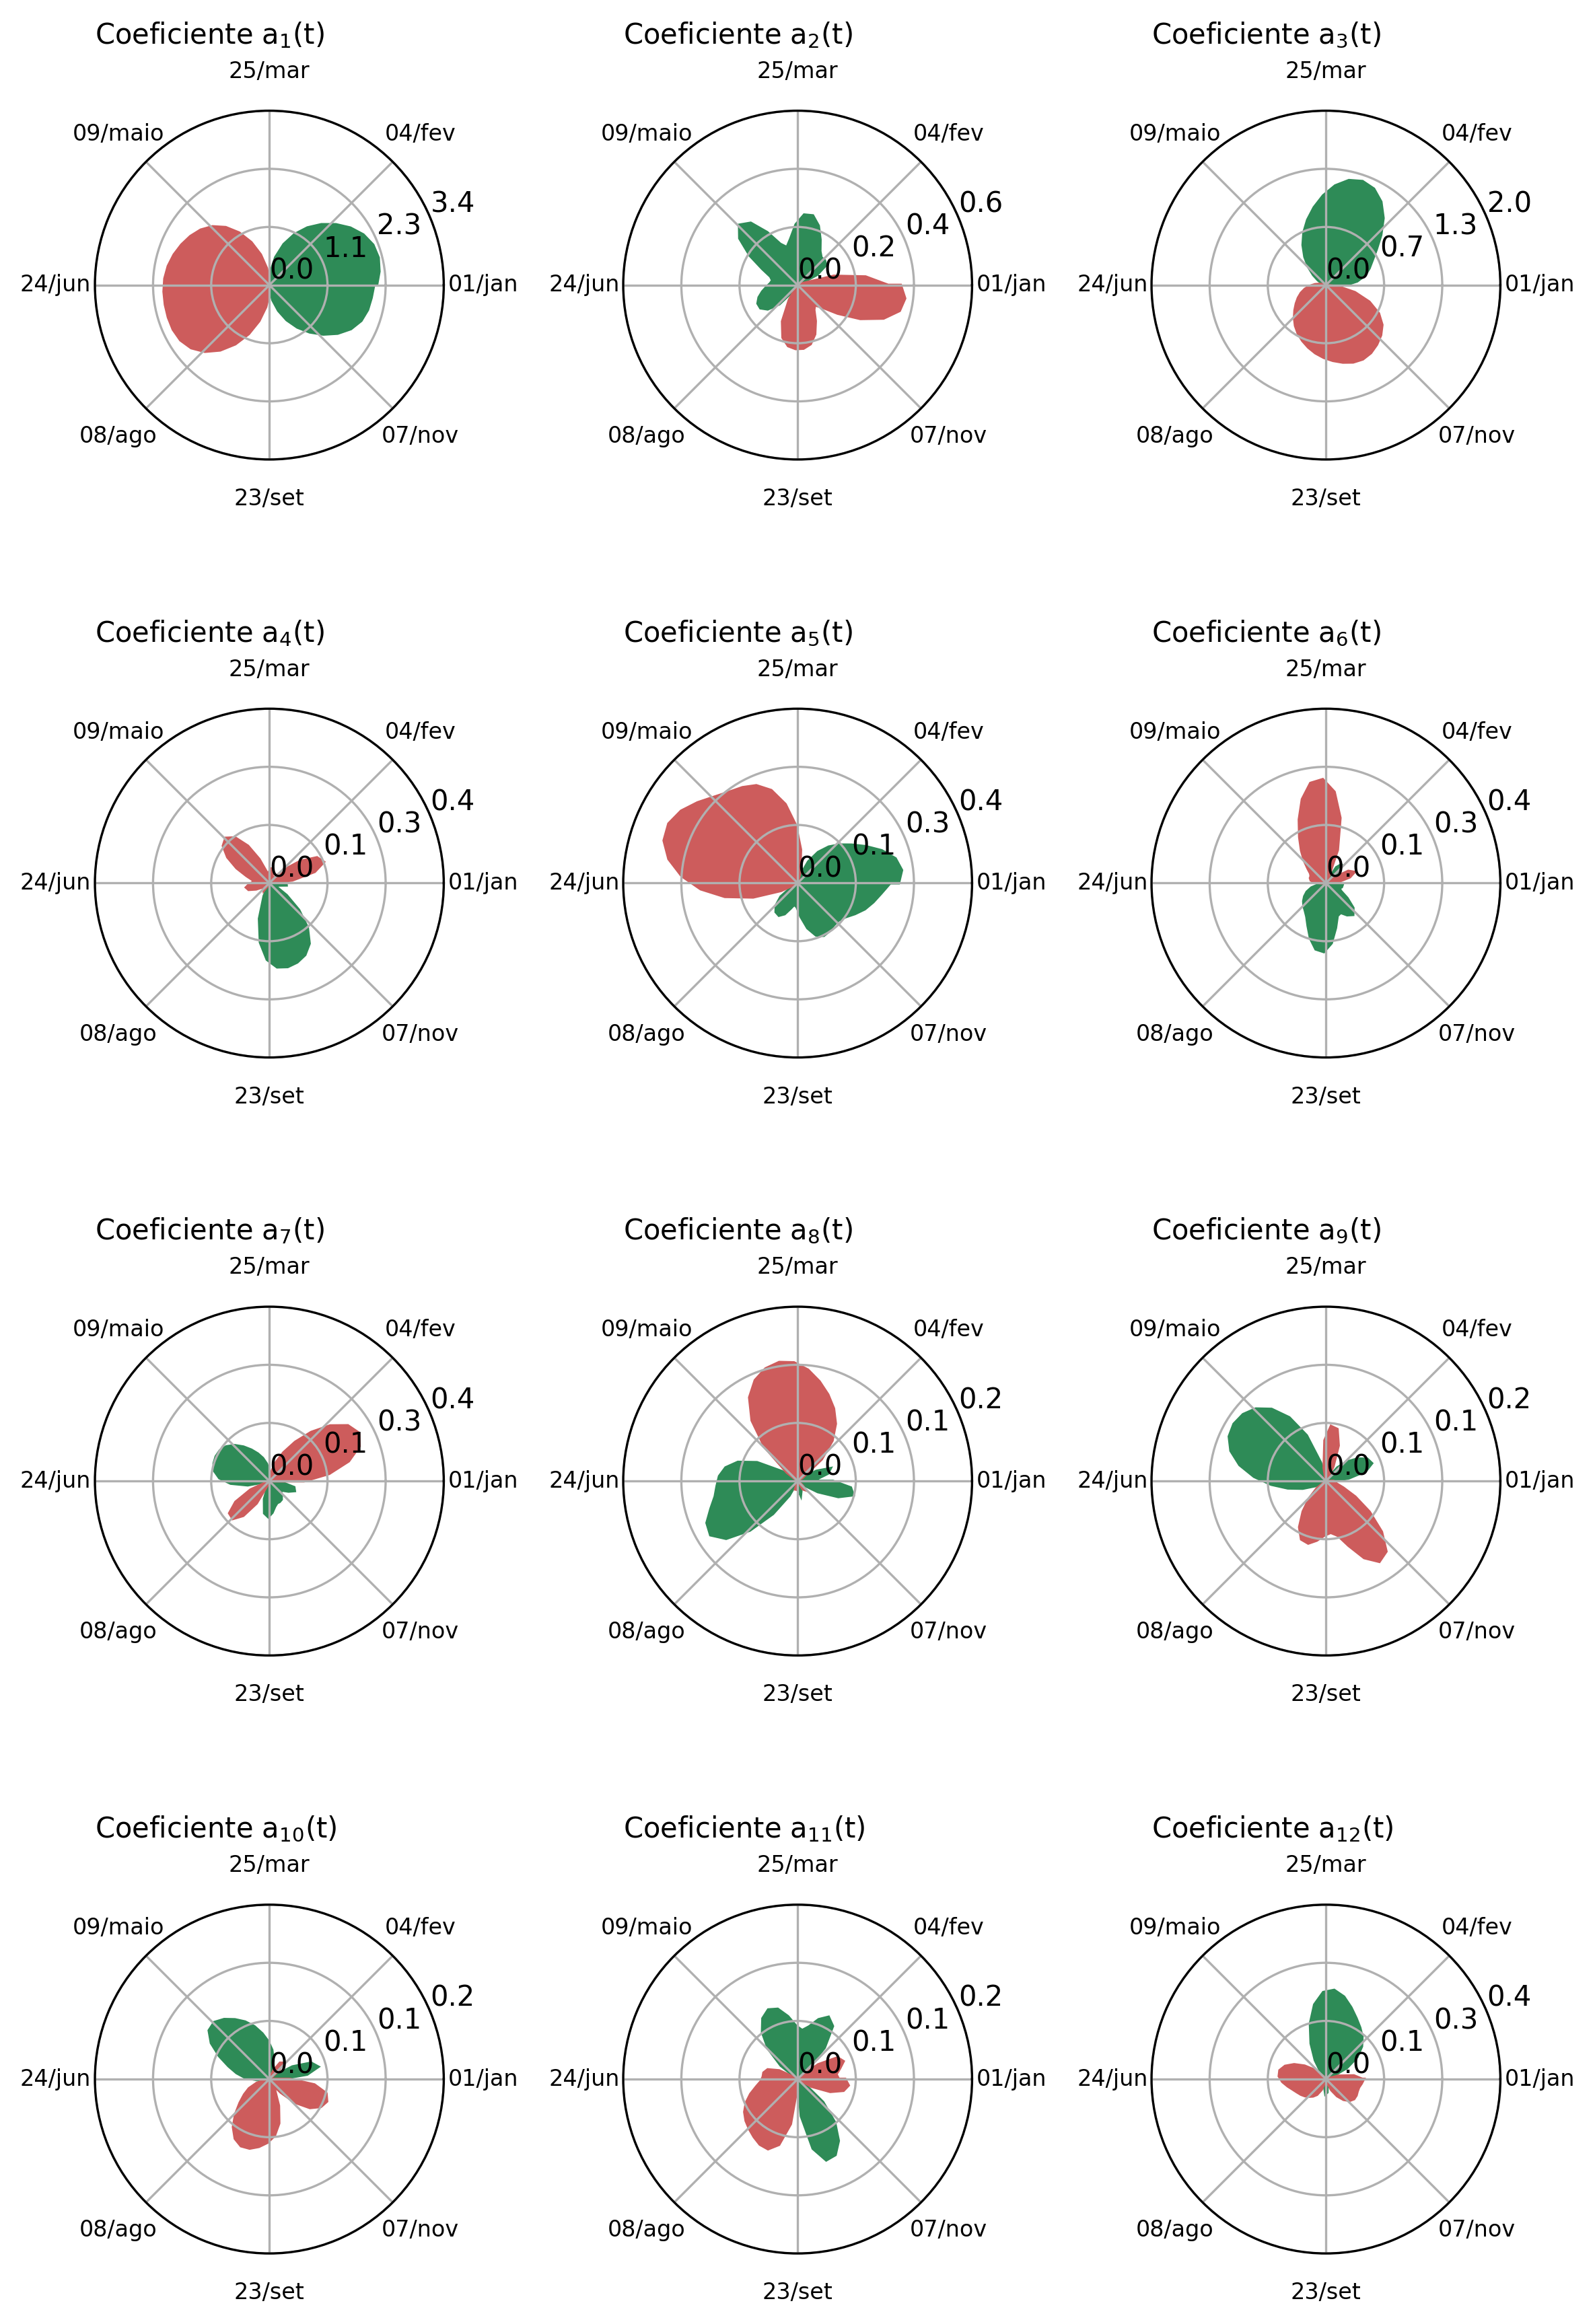

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter as gf

%matplotlib inline

fig, ax = plt.subplots(ncols=3, nrows=4, figsize=(8, 12), dpi=300, subplot_kw={'projection': 'polar'})

nomes = ['01/jan','04/fev','25/mar','09/maio','24/jun','08/ago','23/set','07/nov']

# Função para plotar dados em um subplot específico
def plot_subplot(ax, k, A):
    r = gf(A[:-1, k].reshape(14, 52)[:, 0:52].mean(axis=0), 2, mode='wrap')
    theta = (2*np.pi*np.linspace(0, 360, 52)/360)

    r_mais = r.copy()
    r_mais[r_mais < 0] = 0

    r_menos = r.copy()
    r_menos[r_menos > 0] = 0

    ax.fill(theta, np.abs(r_mais), color='seagreen')
    ax.fill(theta, np.abs(r_menos), color='indianred')
    r_max = 1.5 * r.max()

    # Fixando os ticks radiais em múltiplos de 0.5
    r_max_rounded = np.ceil(r_max/0.1)*0.1  # Arredondar para o próximo múltiplo de 0.5
    ticks = np.linspace(0, np.ceil(5*r_max_rounded)/5, 4)
    
    ax.set_yticks(ticks)
    ax.set_yticklabels([f'{tick:.1f}' for tick in ticks])

    ax.set_xticklabels(nomes, fontsize=8)
    ax.set_title("Coeficiente " + r"a$_{"+str(k+1)+"}$(t)", loc='left', fontsize=10)
    ax.grid(True)

# Loop para preencher os subplots
for i in range(4):
    for j in range(3):
        k = i * 3 + j  # Índice k que percorre de 0 a 11
        if k < 12:  # Garantindo que não acessamos índices fora do limite
            plot_subplot(ax[i, j], k, A)
        else:
            ax[i, j].axis('off')  # Ocultar subplots não utilizados

plt.tight_layout()
#plt.savefig('Polar_4x3.png')
#plt.show()


### Resultados Por Estado

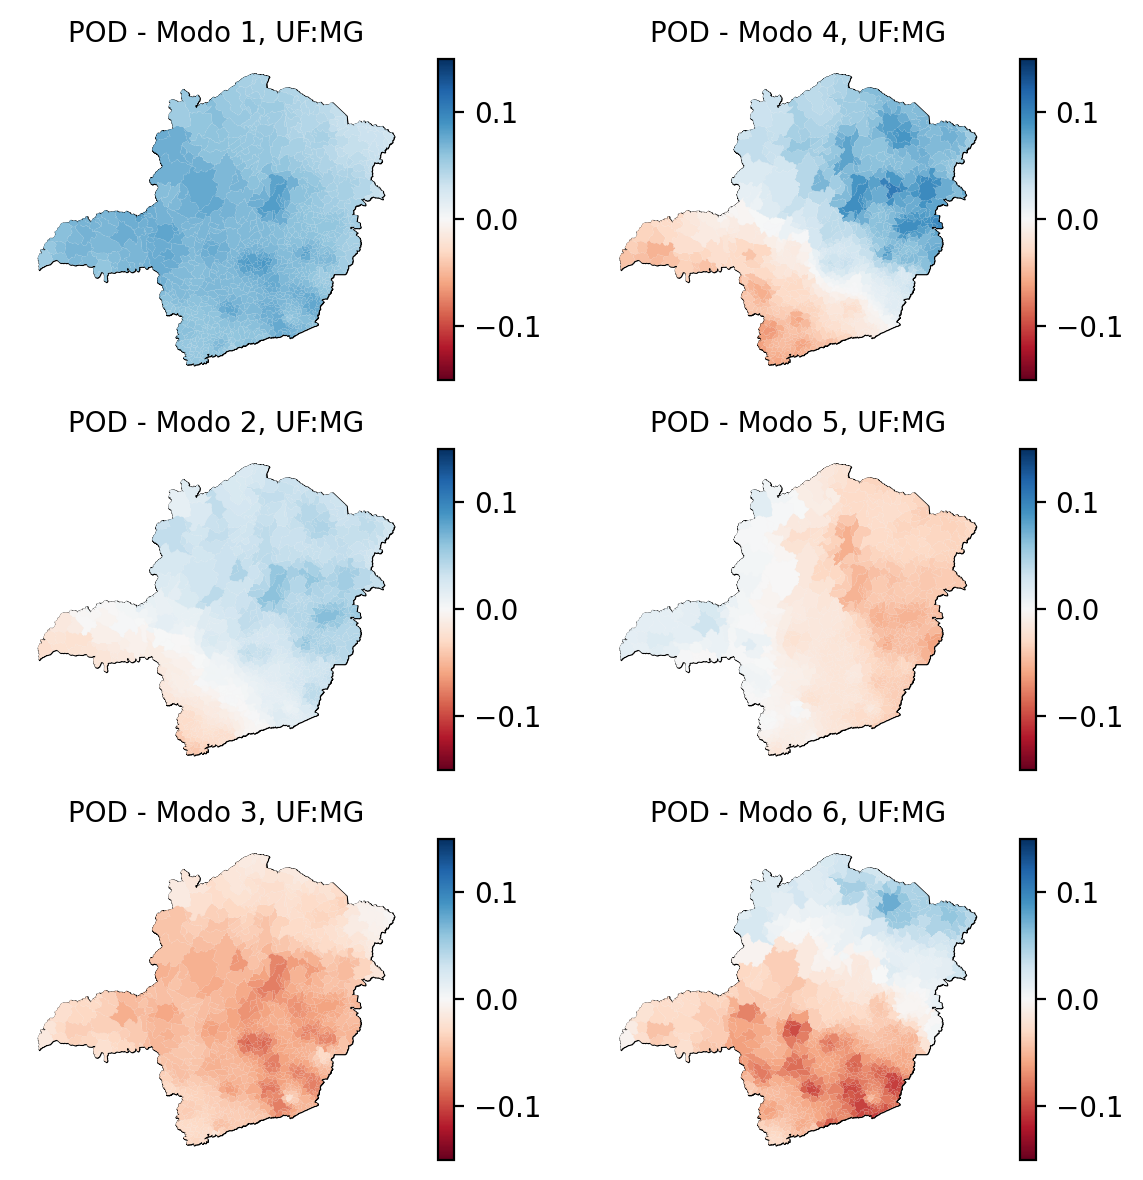

In [74]:
uf = 'MG'
%matplotlib inline
fig, ax = plt.subplots(ncols=2, nrows=3 ,figsize=(6, 6),dpi=200)

for k in np.arange(3):          
    UF.loc[(UF['SIGLA_UF']==uf)].plot(facecolor="whitesmoke", edgecolor="black", ax=ax[k,0],lw=0.5)
    Cidades_Full.loc[(Cidades_Full['SIGLA_UF']==uf)].plot(ax=ax[k,0],column=f"Modo_{k+1}",cmap='RdBu',legend=True,vmin=-0.15,vmax=0.15)
    ax[k,0].set_title(f"POD - Modo {k+1}, UF:{uf}", fontsize=10)
    ax[k,0].axis("off")

for k in np.arange(3,6):          
    UF.loc[(UF['SIGLA_UF']==uf)].plot(facecolor="whitesmoke", edgecolor="black", ax=ax[k-3,1],lw=0.5)
    v = max(np.abs(Cidades_Full[f'Modo_{k+1}'].min()), np.abs(Cidades_Full[f'Modo_{k+1}'].max())  )
    Cidades_Full.loc[(Cidades_Full['SIGLA_UF']==uf)].plot(ax=ax[k-3,1],column=f"Modo_{k+1}",cmap='RdBu',legend=True,vmin=-0.15,vmax=0.15)
    ax[k-3,1].set_title(f"POD - Modo {k+1}, UF:{uf}", fontsize=10)
    ax[k-3,1].axis("off")

plt.tight_layout()
plt.savefig('Modos_MG.png')

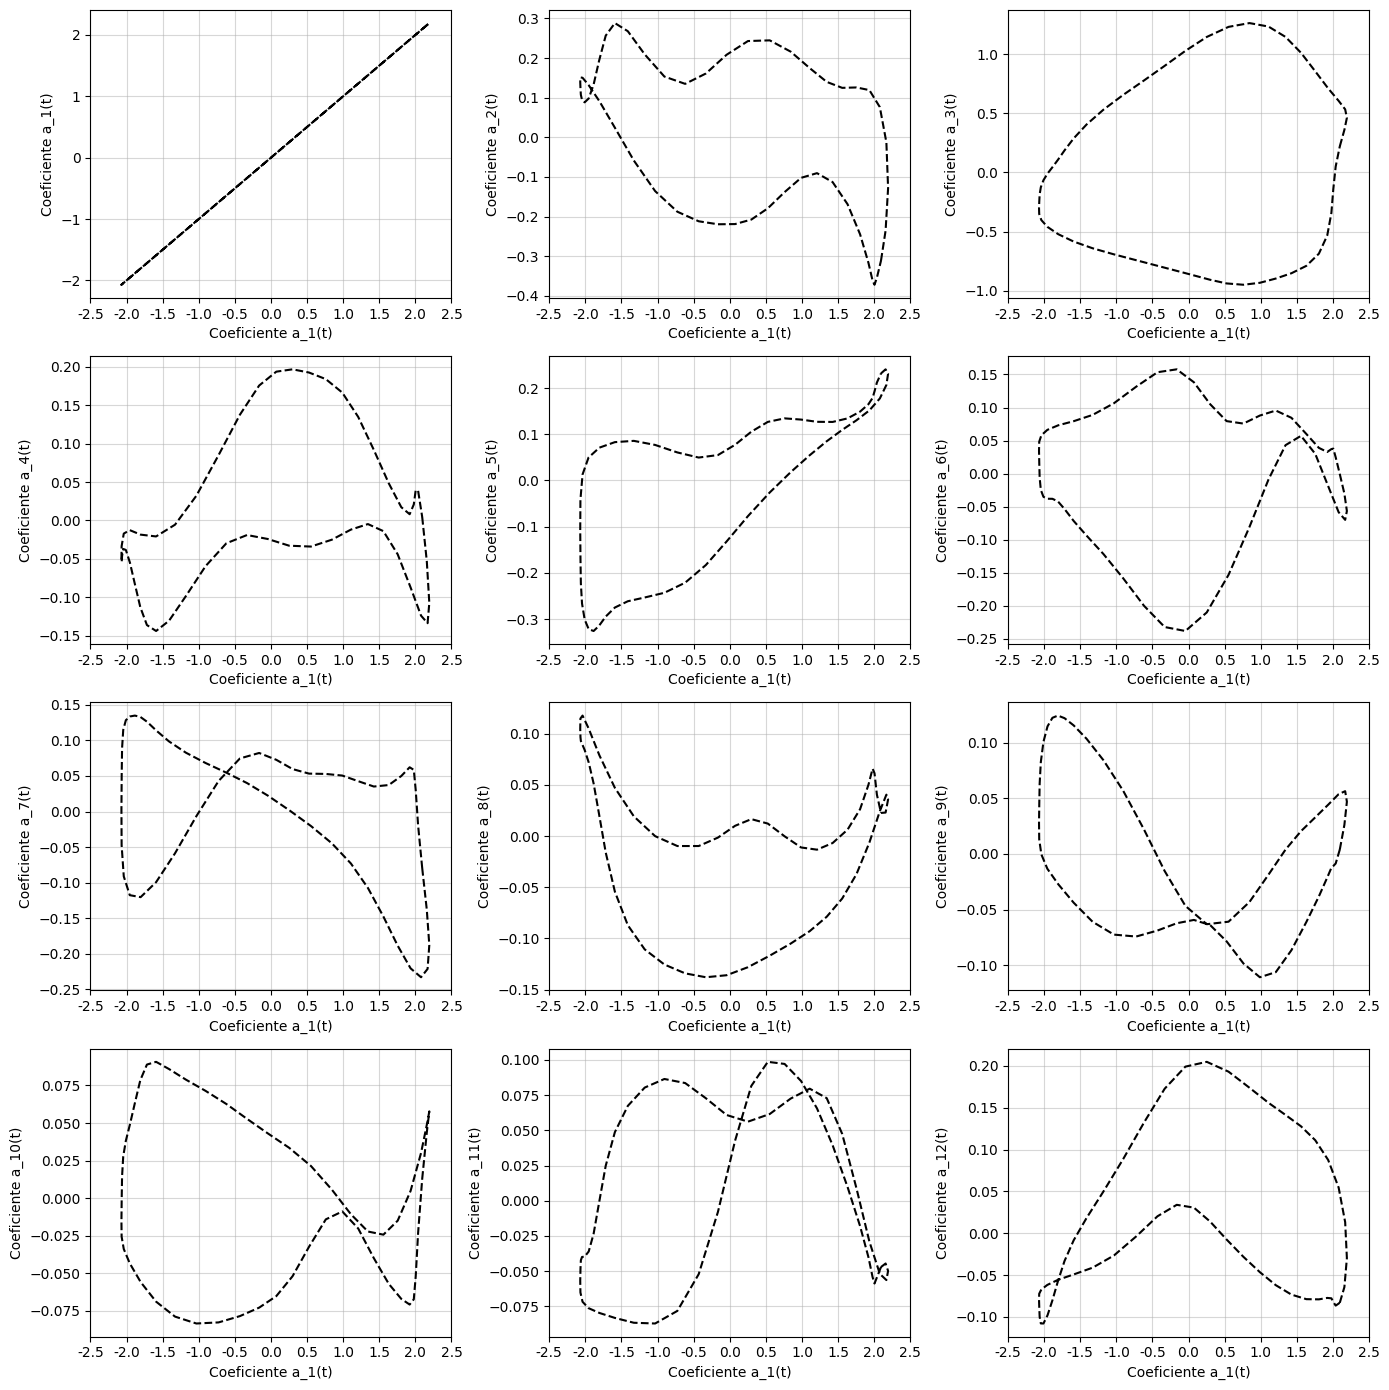

In [59]:
plt.figure(figsize=(14, 14))
for i in np.arange(12):
     plt.subplot(4,3,i+1)

     a0 = gf(A[:-1, 0].reshape(14, 52).mean(axis=0), 2, mode='wrap')
     ak = gf(A[:-1, i].reshape(14, 52).mean(axis=0), 2, mode='wrap')

     a0 = np.append(a0, a0[0])
     ak = np.append(ak, ak[0])
     plt.xlim(-2.5,2.5)
     plt.xticks(np.arange(-2.5,2.6,0.5),np.arange(-2.5,2.6,0.5))

     plt.plot( a0, ak, 'k--')
     plt.ylabel(f'Coeficiente a_{i+1}(t)')
     plt.xlabel(f'Coeficiente a_{1}(t)')
     plt.grid(alpha=0.5)


plt.tight_layout()

plt.savefig('1xtodos.png',dpi=300)

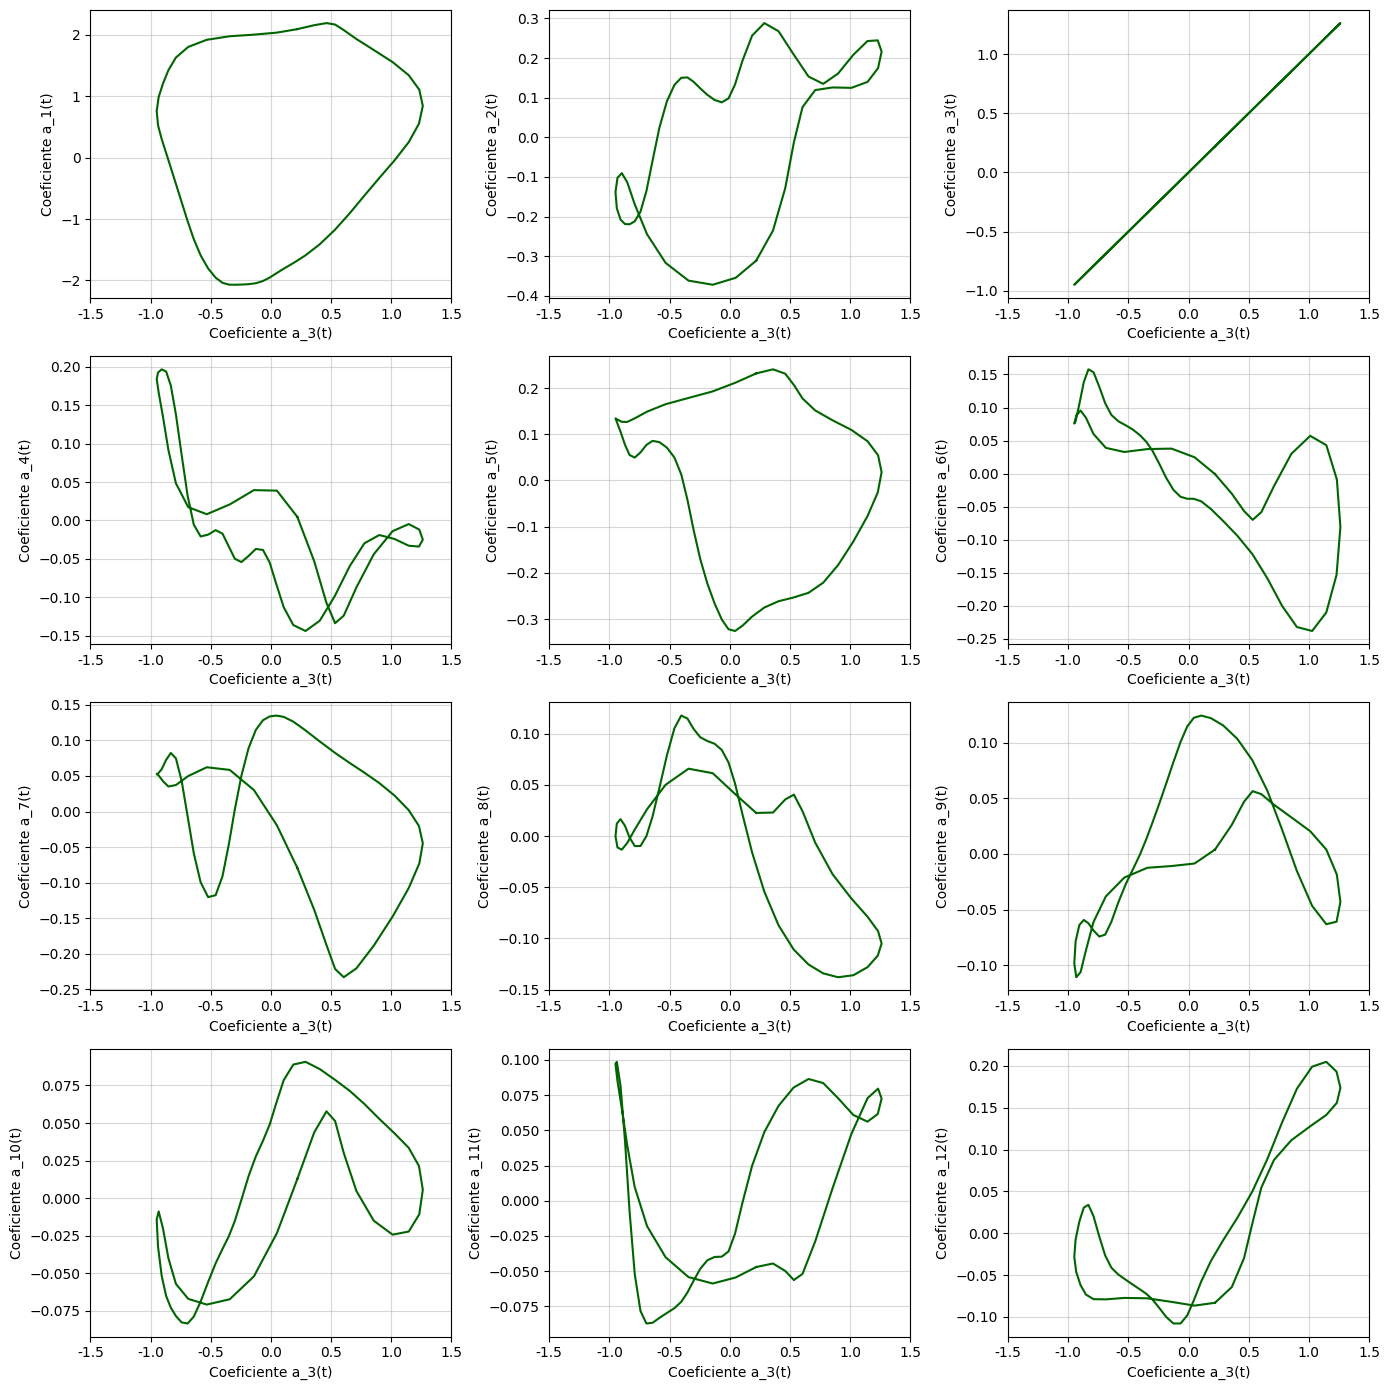

In [62]:
plt.figure(figsize=(14, 14))
for i in np.arange(12):
     plt.subplot(4,3,i+1)

     a0 = gf(A[:-1, 2].reshape(14, 52).mean(axis=0), 2, mode='wrap')
     ak = gf(A[:-1, i].reshape(14, 52).mean(axis=0), 2, mode='wrap')

     a0 = np.append(a0, a0[0])
     ak = np.append(ak, ak[0])
     #plt.xlim(-1.5,1.5)
     plt.xticks(np.arange(-2.5,2.6,0.5),np.arange(-2.5,2.6,0.5))
     plt.xlim(-1.5,1.5)
     plt.plot( a0, ak, c='darkgreen',ls='-')
     plt.ylabel(f'Coeficiente a_{i+1}(t)')
     plt.xlabel(f'Coeficiente a_{3}(t)')
     plt.grid(alpha=0.5)


plt.tight_layout()

plt.savefig('3xtodos.png',dpi=300)